# Segmentation Model Training

This notebook has been repurposed from [Balraj Ashwath's](https://www.kaggle.com/code/balraj98/pyramid-attention-network-pan-resnet50-pytorch) implementation.

In [3]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [4]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

### Load data dn make test-train splits

In [5]:
DATA_DIR = './data'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_path', 'label_type', 'label_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['label_path'] = metadata_df['label_path'].apply(lambda lbl_pth: os.path.join(DATA_DIR, 'labels', lbl_pth))

# Select data with segmentation masks
metadata_df = metadata_df[metadata_df['label_type']=='pixel-level']

# randomize data samples
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# split data 90/10 for train / val
valid_df = metadata_df.sample(frac=0.05, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(954, 50)

#### Select classes that are of interest

In [6]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['class_name'].tolist()
# Rewriting 'null' class to prevent a NaN value
class_names[0] = 'null'
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit',
                  'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress',
                  'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie',
                  'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace',
                  'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf',
                  'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings',
                  'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie',
                  'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

### A bunch of helper functions

In [7]:
# helper function for data visualization
def visualize(**images):
    """
    print images
    """
    n = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# one-hot encoding for a label
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map


# reverse one-hot-encoding for labels or prediction
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x


# colour coding on reverse-one-hot array
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

### Make a class for the dataset

In [8]:
class ClothesDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # load image and mask
        image = cv2.imread(self.image_paths[i])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[i])[:,:,::-1]

        # one-hot-encode mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # augment
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # pre-process
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

### Data augmentation for regularization

In [9]:
def get_training_augmentation():
    """
    Data augmentation for regularization
    """
    train_transform = [
        album.ShiftScaleRotate(scale_limit=0.16, rotate_limit=30, shift_limit=0.16, p=0.8, border_mode=0),
        album.RandomCrop(height=384, width=384, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    """
    Make image divisible by 16 by adding pads
    """
    test_transform = [
        album.PadIfNeeded(min_height=896, min_width=576, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """
    Compose preprocessing transformations
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

## Model Training

### Model Init

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

# make segmentation model with imagenet weight initialization for encoder
model = smp.PAN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 410MB/s]


#### Initialize Train and Val DataLoaders

In [11]:
# Get train and val datasets wrapped up in a class structure
train_dataset = ClothesDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = ClothesDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

#### Define Hyperparameters

In [12]:
# Set num of epochs
EPOCHS = 3

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = utils.losses.DiceLoss()

# define metrics
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Training Pyramid Attention Network

In [14]:
%%time

best_iou_score = 0.0
train_logs_list, valid_logs_list = [], []

for i in range(0, EPOCHS):

    # Perform training & validation
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    train_logs_list.append(train_logs)
    valid_logs_list.append(valid_logs)

    # Save model if a better val IoU score is obtained
    if best_iou_score < valid_logs['iou_score']:
        best_iou_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it, dice_loss - 0.6401, iou_score - 0.5769]
Model saved!

Epoch: 1
train:   0%|          | 0/80 [00:03<?, ?it/s]


KeyboardInterrupt: 

### Prediction on Test Data

In [15]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded PAN model from this run.')

Loaded PAN model from this run.


In [20]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = ClothesDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization
test_dataset_vis = ClothesDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

In [21]:
# crop prediction to original image size
def crop_image(image, true_dimensions):
    return album.CenterCrop(p=1, height=true_dimensions[0], width=true_dimensions[1])(image=image)

In [22]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

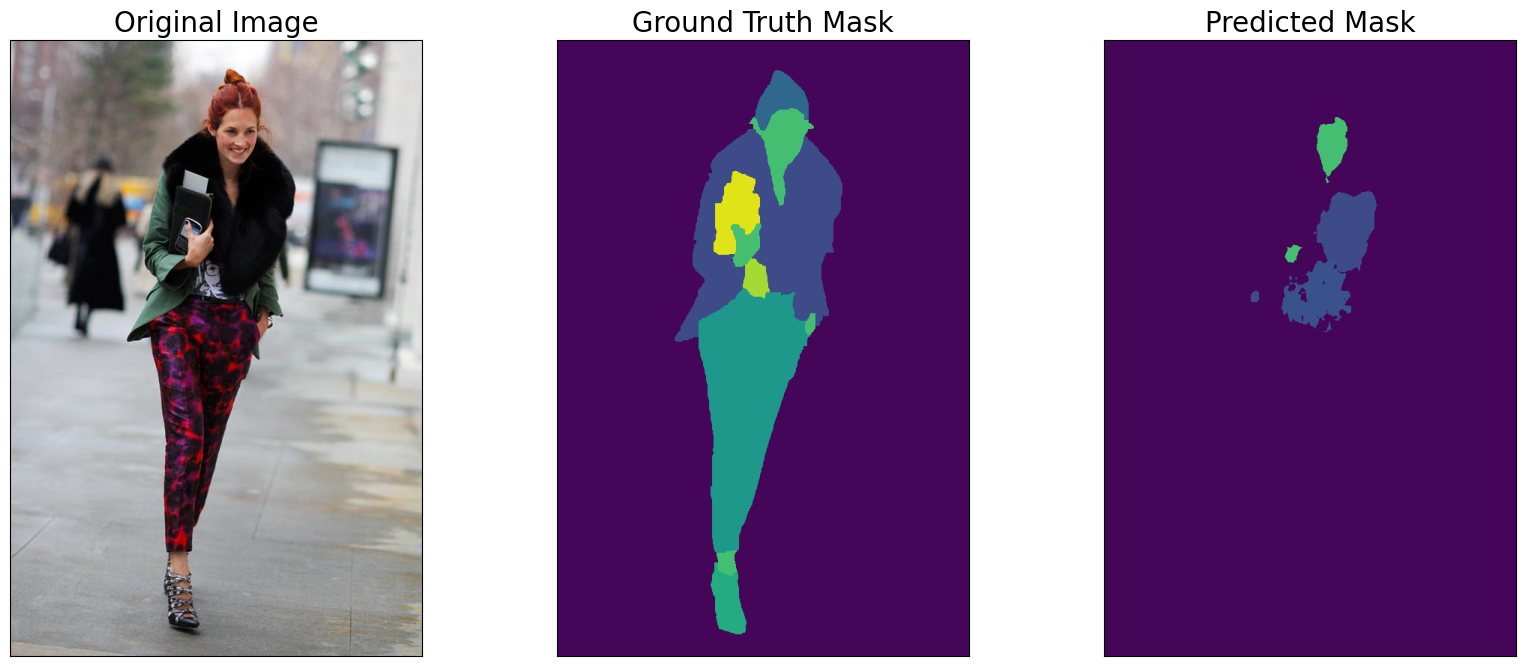

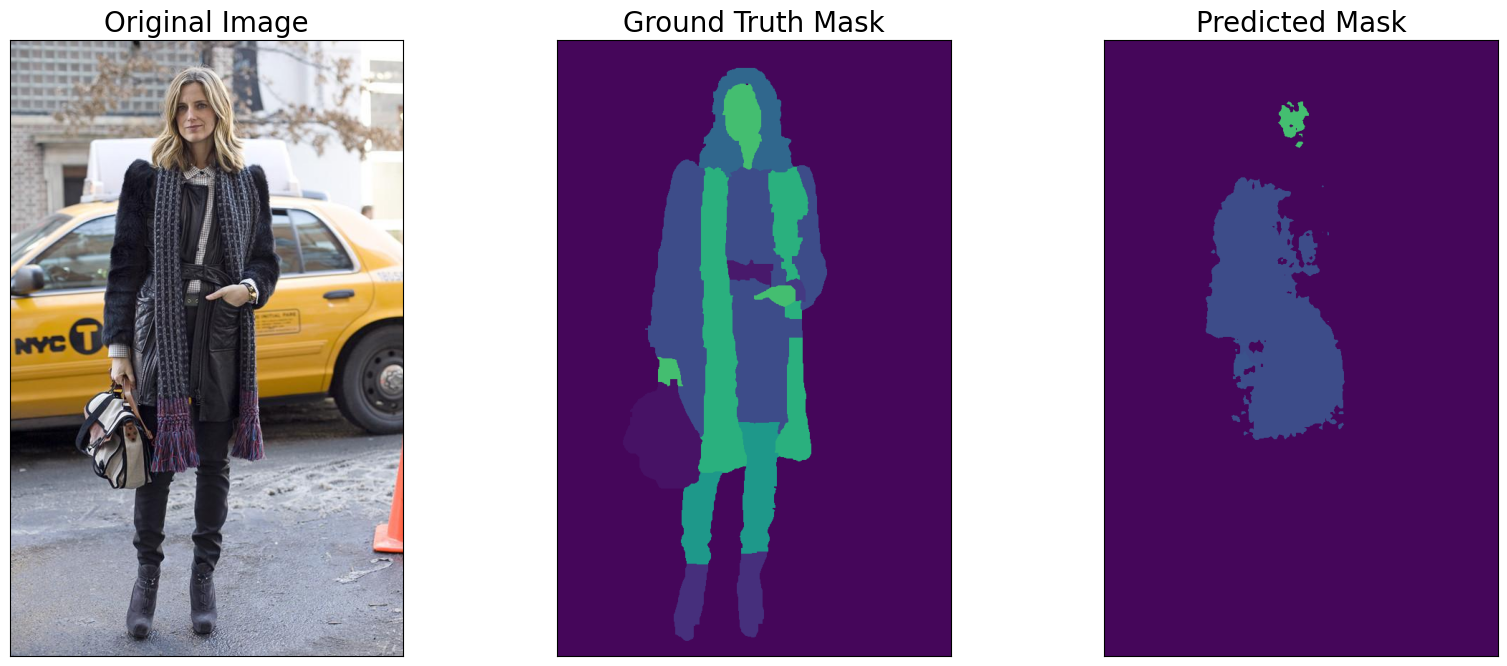

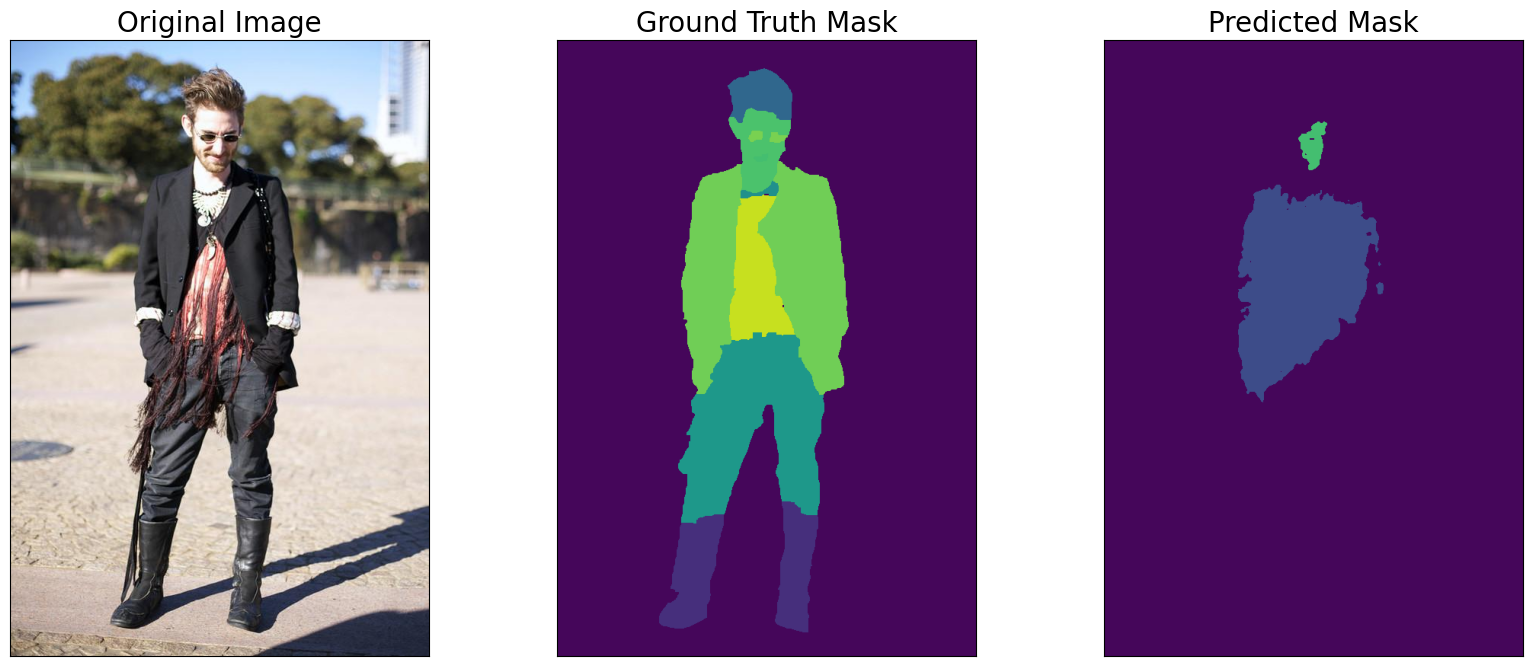

In [24]:
for idx in range(3):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    true_dimensions = image_vis.shape
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values), true_dimensions)['image']
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values), true_dimensions)['image']
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
    )

### Model Evaluation on Test Dataset

In [25]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 50/50 [01:32<00:00,  1.85s/it, dice_loss - 0.6412, iou_score - 0.5742]
Evaluation on Test Data: 
Mean IoU Score: 0.5742
Mean Dice Loss: 0.6412


### Save training logs

In [ ]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.to_pickle("train_logs"), valid_logs_df.to_pickle("valid_logs")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,0.890947,0.415747,0.270271,0.246555,0.225610,0.221425,0.213219,0.20845,0.210125,0.199108,0.199912,0.200411,0.200742,0.192344,0.191848,0.187638,0.187536,0.185843,0.184664,0.174872
iou_score,0.115705,0.541058,0.610099,0.626669,0.650787,0.653326,0.663011,0.66822,0.664625,0.678937,0.677398,0.675658,0.675300,0.686514,0.686926,0.692832,0.692031,0.694275,0.695707,0.709677


(None, None)